Get the data from wandb and plot them however we want.

In [2]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Any


SMOOTHING = ["smoothed", "unsmoothed"]
SUBSETS = ["all", "subgram", "suffix"]
NGRAMS = list(range(1, 8))

KEYS = [
    "_step",
    *[f"top_1/{t}_{s}_{i}" for t in SMOOTHING for s in SUBSETS for i in NGRAMS],
    *[f"variation_distance/{t}_{s}_{i}" for t in SMOOTHING for s in SUBSETS for i in NGRAMS],
]

def get_run_data(run_path: str) -> Dict[str, Any]:
    api = wandb.Api()
    run = api.run(run_path)
    return pd.DataFrame(run.history(keys=KEYS, samples=100000))


In [3]:
IDS = {
    "strange_textbooks": "twqaohdu",
    "tinystories": "yuru295z",
    "hungarian_wikipedia": "shiucpbr",
    "english_wikipedia": "s5vbuwz0"
}

data = {
    k: get_run_data(f"bjarnih/ngram-llm-analysis/{v}") for k, v in IDS.items()
}


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


In [4]:
NGRAM_COLORS = {
    1: "#FF1E1E",    # Vibrant red
    2: "#FF7E1E",    # Orange-red
    3: "#FFC11E",    # Golden yellow
    4: "#22C55E",    # Emerald green
    5: "#0EA5E9",    # Sky blue
    6: "#4F46E5",    # Indigo
    7: "#7E22CE"     # Purple
}

DATASET_COLORS = {
    "strange_textbooks": "#2DD4BF",           # Teal
    "tinystories": "#F472B6",       # Pink
    "hungarian_wikipedia": "#FB923C", # Orange
    "english_wikipedia": "#818CF8"   # Light purple
}

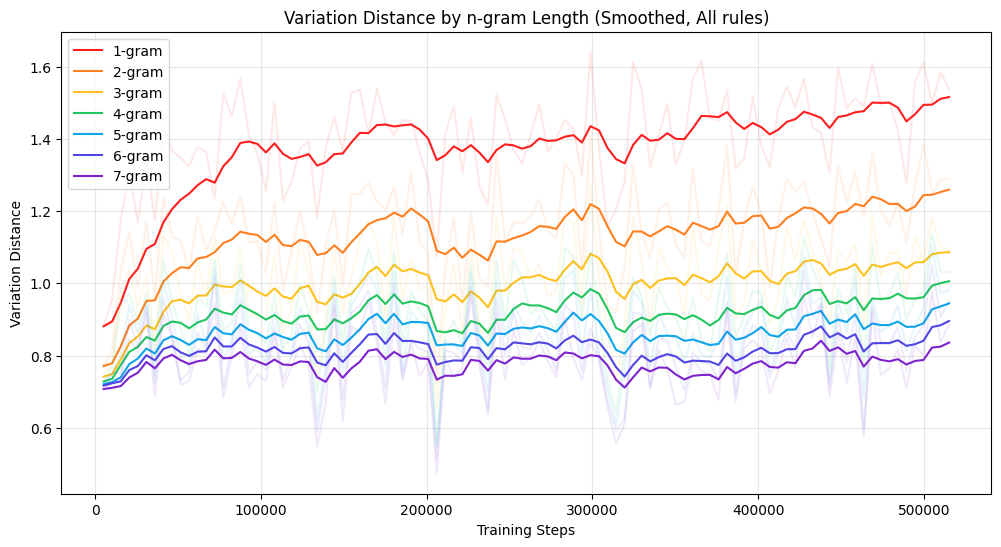

In [19]:
def ema(series: pd.Series, window: int) -> pd.Series:
    return series.ewm(span=window, adjust=False).mean()

def plot_one_run_ngram_metric(data: pd.DataFrame, metric_type: str, smoothing: str = "unsmoothed", subset: str = "all", ax=None):
    if ax is None:
        fig = plt.figure(figsize=(12, 6))
        ax = fig.gca()
    
    for n in NGRAMS:
        raw = data[f"{metric_type}/{smoothing}_{subset}_{n}"]
        smoothed = ema(raw, window=10)
        steps = data["_step"]
        
        ax.plot(steps, raw, color=NGRAM_COLORS[n], alpha=0.1)
        ax.plot(steps, smoothed, color=NGRAM_COLORS[n], alpha=1, label=f"{n}-gram")

    ax.set_xlabel("Training Steps")
    
    if metric_type == "variation_distance":
        ylabel = "Variation Distance"
    elif metric_type == "top_1":
        ylabel = "Top-1 Accuracy"
    ax.set_ylabel(ylabel)
    
    title_metric = "Variation Distance" if metric_type == "variation_distance" else "Top-1 Accuracy"
    ax.set_title(f"{title_metric} by n-gram Length ({smoothing.title()}, {subset.title()} rules)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    return ax
    
a = plot_one_run_ngram_metric(data["strange_textbooks"], "variation_distance", "smoothed", "all")

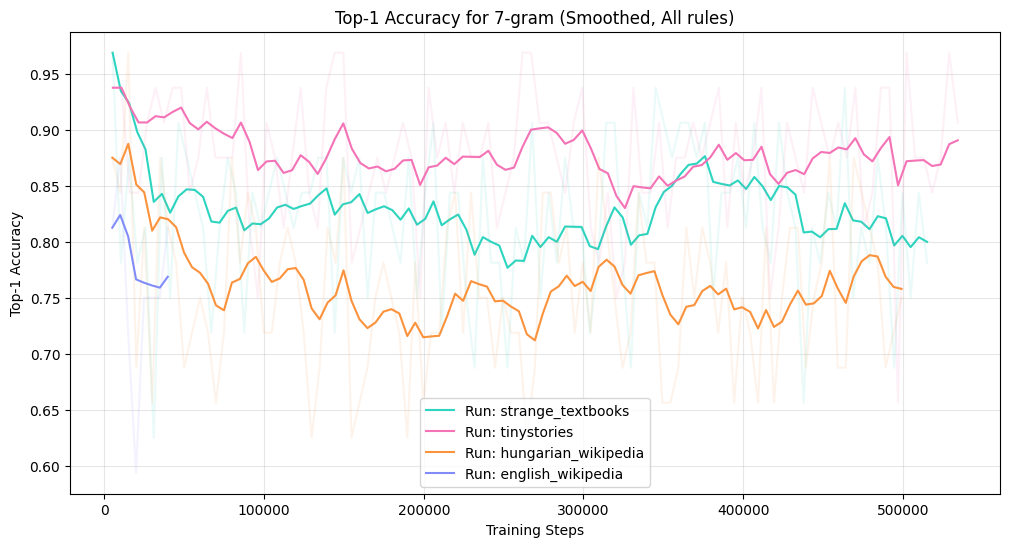

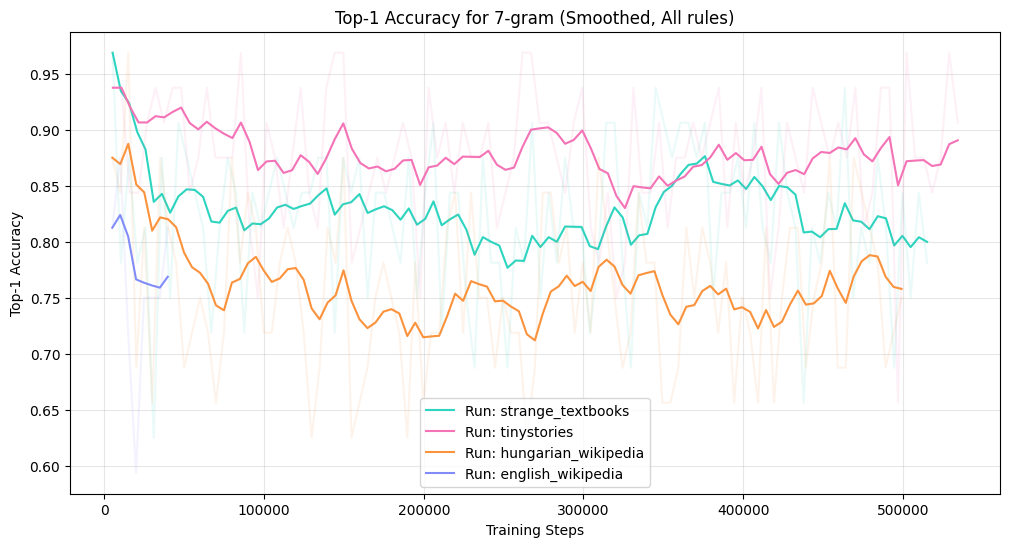

In [20]:
def plot_many_run_ngram_metric(data: Dict[str, pd.DataFrame], metric_type: str, smoothing: str = "unsmoothed", subset: str = "all", n_gram: int = 7):
    fig = plt.figure(figsize=(12, 6))
    
    for run_name, df in data.items():
        raw = df[f"{metric_type}/{smoothing}_{subset}_{n_gram}"]
        smoothed = ema(raw, window=10)
        steps = df["_step"]
        
        plt.plot(steps, raw, color=DATASET_COLORS[run_name], alpha=0.1)
        plt.plot(steps, smoothed, color=DATASET_COLORS[run_name], alpha=1, label=f"Run: {run_name}")

    plt.xlabel("Training Steps")
    
    if metric_type == "variation_distance":
        ylabel = "Variation Distance"
    elif metric_type == "top_1":
        ylabel = "Top-1 Accuracy"
    plt.ylabel(ylabel)
    
    title_metric = "Variation Distance" if metric_type == "variation_distance" else "Top-1 Accuracy"
    plt.title(f"{title_metric} for {n_gram}-gram ({smoothing.title()}, {subset.title()} rules)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    return fig

plot_many_run_ngram_metric(data, "top_1", "smoothed", "all", 7)

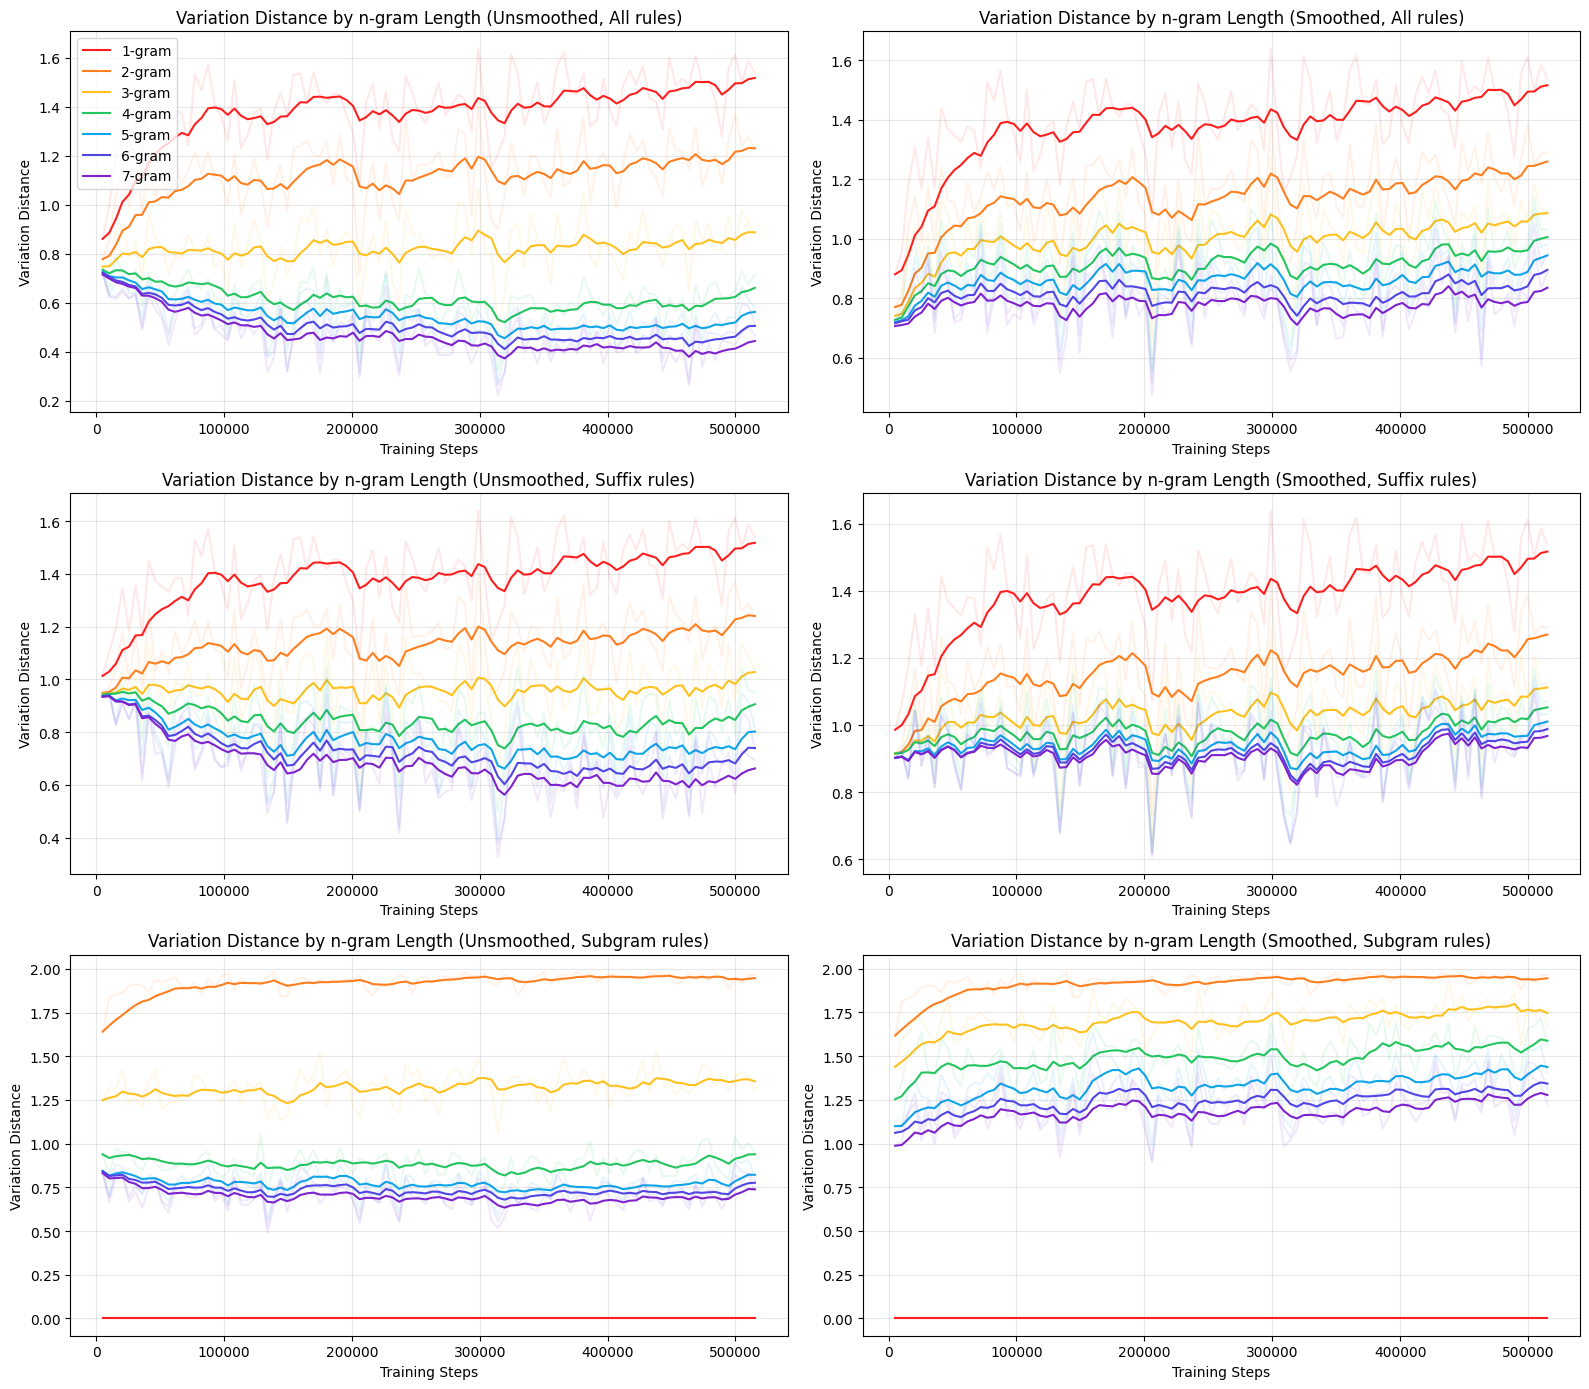

In [28]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 14))
ax1 = plot_one_run_ngram_metric(data["strange_textbooks"], "variation_distance", "unsmoothed", "all", ax1)
ax2 = plot_one_run_ngram_metric(data["strange_textbooks"], "variation_distance", "smoothed", "all", ax2)
ax2.legend().remove()
ax3 = plot_one_run_ngram_metric(data["strange_textbooks"], "variation_distance", "unsmoothed", "suffix", ax3)
ax3.legend().remove()
ax4 = plot_one_run_ngram_metric(data["strange_textbooks"], "variation_distance", "smoothed", "suffix", ax4)
ax4.legend().remove()
ax5 = plot_one_run_ngram_metric(data["strange_textbooks"], "variation_distance", "unsmoothed", "subgram", ax5)
ax5.legend().remove()
ax6 = plot_one_run_ngram_metric(data["strange_textbooks"], "variation_distance", "smoothed", "subgram", ax6)
ax6.legend().remove()
fig.tight_layout()
